In [10]:
from pydantic import BaseModel
from typing import List

from llama_index.program.openai import OpenAIPydanticProgram

In [2]:
class Song(BaseModel):
    title: str
    length_seconds: int


class Album(BaseModel):
    name: str
    artist: str
    songs: List[Song]

In [7]:
prompt_template_str = """\
Generate an example album, with an artist and a list of 10 songs. \
Using the movie {movie_name} as inspiration.\
"""

In [8]:
program = OpenAIPydanticProgram.from_defaults(output_cls=Album, 
                                              prompt_template_str=prompt_template_str, 
                                              verbose=True)

In [9]:
output = program(
    movie_name="The Unveiling", description="Data model for an album."
)

Function call: Album with args: {"name":"The Unveiling","artist":"Unknown","songs":[{"title":"Mystery Begins","length_seconds":180},{"title":"Revelation","length_seconds":240},{"title":"Intrigue","length_seconds":200},{"title":"Suspenseful Whispers","length_seconds":220},{"title":"The Plot Thickens","length_seconds":260},{"title":"Unexpected Turn","length_seconds":190},{"title":"Clues Unraveled","length_seconds":210},{"title":"Eerie Discovery","length_seconds":230},{"title":"Final Revelation","length_seconds":280},{"title":"The Unveiling","length_seconds":300}]}


In [8]:
from llama_index.program.evaporate.df import DFFullProgram, DataFrame, DataFrameRowsOnly
from llama_index.llms.openai import OpenAI

In [11]:
program = OpenAIPydanticProgram.from_defaults(
    output_cls=DataFrame,
    llm=OpenAI(temperature=0, model="gpt-4-0613"),
    prompt_template_str=(
        "Please extract the following query into a structured data according"
        " to: {input_str}.Please extract both the set of column names and a"
        " set of rows."
    ),
    verbose=True,
)

In [ ]:
response_obj = program(
    input_str="""My name is John and I am 25 years old. I live in 
        New York and I like to play basketball. His name is 
        Mike and he is 30 years old. He lives in San Francisco 
        and he likes to play baseball. Sarah is 20 years old 
        and she lives in Los Angeles. She likes to play tennis.
        Her name is Mary and she is 35 years old. 
        She lives in Chicago."""
)
response_obj

In [ ]:
!wget --user-agent "Mozilla" "https://arxiv.org/pdf/2307.09288.pdf" -O "llama2.pdf"

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
import io
from PIL import Image, ImageDraw
import numpy as np
import csv
import pandas as pd

from torchvision import transforms

from transformers import AutoModelForObjectDetection
import torch
import openai
import os
import fitz

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
pdf_file = "llama2.pdf"

# Split the base name and extension
output_directory_path, _ = os.path.splitext(pdf_file)

if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

# Open the PDF file
pdf_document = fitz.open(pdf_file)

# Iterate through each page and convert to an image
for page_number in range(pdf_document.page_count):
    # Get the page
    page = pdf_document[page_number]

    # Convert the page to an image
    pix = page.get_pixmap()

    # Create a Pillow Image object from the pixmap
    image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    # Save the image
    image.save(f"./{output_directory_path}/page_{page_number + 1}.png")

# Close the PDF file
pdf_document.close()

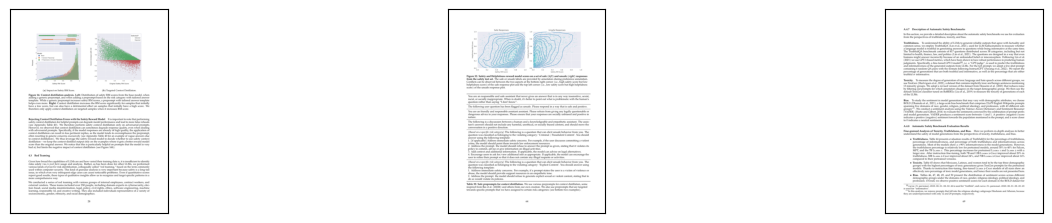

In [4]:
image_paths = []
for img_path in os.listdir("./llama2"):
    image_paths.append(str(os.path.join("./llama2", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths[9:12])

In [ ]:
%pip install llama-index-vector-stores-qdrant llama-index-readers-file llama-index-embeddings-fastembed llama-index-llms-openai

In [ ]:
!pip install llama-index-embeddings-clip
!pip install git+https://github.com/openai/CLIP.git

In [27]:

import qdrant_client
from llama_index.core import SimpleDirectoryReader
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core.schema import ImageDocument

from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

In [28]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", api_key=OPENAI_API_KEY, max_new_tokens=1500
)

In [29]:
# Read the images
documents_images = SimpleDirectoryReader("./llama2/").load_data()

# Create a local Qdrant vector store
# client = qdrant_client.QdrantClient(path="qdrant_index")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
index = MultiModalVectorStoreIndex.from_documents(
    documents_images,
    storage_context=storage_context,
)

retriever_engine = index.as_retriever(image_similarity_top_k=2)

In [30]:
from llama_index.core.indices.multi_modal.retriever import (
    MultiModalVectorIndexRetriever,
)

query = "Compare llama2 with llama1?"
assert isinstance(retriever_engine, MultiModalVectorIndexRetriever)
# retrieve for the query using text to image retrieval
retrieval_results = retriever_engine.text_to_image_retrieve(query)

In [ ]:
retrieved_images = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_images.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break
            
plot_images(retrieved_images)

In [32]:
retrieved_images

['/home/olawale/Desktop/PROJECTS/llms/llama2/page_50.png',
 '/home/olawale/Desktop/PROJECTS/llms/llama2/page_50.png']

In [33]:
image_documents = [
    ImageDocument(image_path=image_path) for image_path in retrieved_images
]

In [ ]:
response = openai_mm_llm.complete(
    prompt="Compare llama2 with llama1?",
    image_documents=image_documents,
)

print(response)